# Face Mask Detection using CNN

## Loading the Libraries and Dataset
### Load Libs

In [46]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import regularizers, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

### Load dataset

In [47]:
# Path to dataset directory
dataset_dir = "../input/face-mask-dataset/FMD_DATASET"

In [48]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Normalizing while loading the dataset

In [49]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.3)
datacheck = datagen.flow_from_directory(
    batch_size=32,
    directory=dataset_dir,
    shuffle=True,
    target_size=(280, 280),
    class_mode='categorical'
)
datacheck.class_indices

Found 14536 images belonging to 3 classes.


{'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2}

### Plotting some images

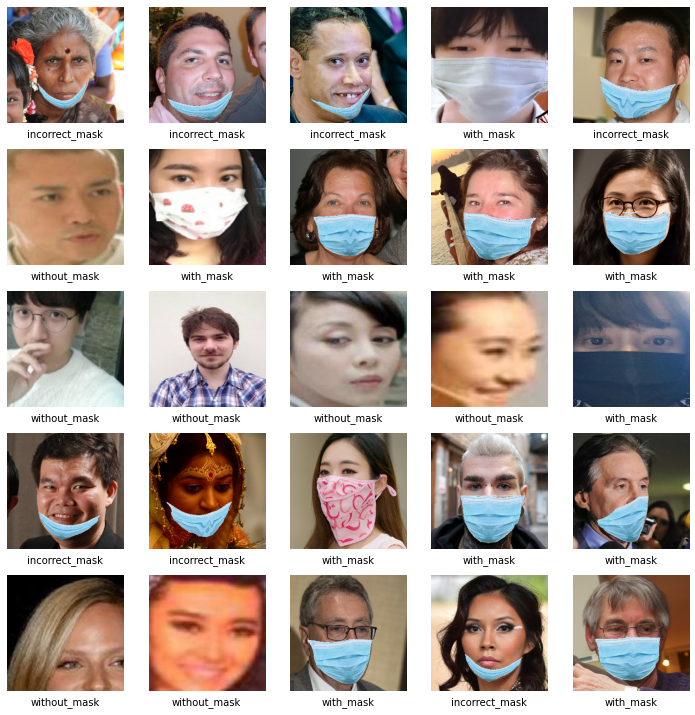

In [50]:
class_indices = datacheck.class_indices
class_labels = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_index = random.randint(0, len(datacheck) - 1)
    image, label = datacheck[random_index]
    plt.imshow(image[0])
    plt.text(0.5, -0.1, class_labels[np.argmax(label)], color='black',
             fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Loading train, test and Val data

In [52]:
train_dataset = datagen.flow_from_directory(
    directory=dataset_dir,
    shuffle=True,
    target_size=(280, 280),
    subset="training",
    class_mode='categorical'
)

Found 10176 images belonging to 3 classes.


In [53]:
val_dataset = datagen.flow_from_directory(
    directory=dataset_dir,
    shuffle=True,
    target_size=(280, 280),
    subset="validation",
    class_mode='categorical'
)

Found 4360 images belonging to 3 classes.


In [54]:
test_dataset = datagen.flow_from_directory(
    directory=dataset_dir,
    shuffle=True,
    target_size=(280, 280),
    subset="validation",
    class_mode='categorical'
)

Found 4360 images belonging to 3 classes.


## Data Preprocessing using custom Function

In [55]:
def preprocess_image(image):
    if image.mode == 'RGBA':
        background = Image.new("RGB", image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[3])  # Appling alpha channel as mask
        return background
    else:
        return image

# Custom generator for preprocessing
class PreprocessingGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator, preprocess_func):
        self.base_generator = base_generator
        self.preprocess_func = preprocess_func

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, idx):
        x, y = self.base_generator[idx]
        x = np.array([img_to_array(self.preprocess_func(img)) for img in x])
        return x, y

In [56]:
train_preprocessed = PreprocessingGenerator(train_dataset, preprocess_image)
val_preprocessed = PreprocessingGenerator(val_dataset, preprocess_image)
test_preprocessed = PreprocessingGenerator(test_dataset, preprocess_image)

## Model Creation

In [57]:
model = Sequential()
model.add(layers.Input(shape = train_dataset.image_shape))
model.add(layers.Conv2D(32, 3, padding ='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dropout(0.05))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.01))
model.add(layers.Conv2D(64, 3, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Conv2D(32, 3, padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128,activation = 'relu'))
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
loss = tf.keras.losses.CategoricalCrossentropy(),
metrics = ['accuracy'])

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 280, 280, 32)      896       
_________________________________________________________________
dropout_4 (Dropout)          (None, 280, 280, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 140, 140, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 140, 140, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 140, 140, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 140, 140, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 70, 70, 32)       

### Training the model

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
epochs = 20

In [60]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stop],
    verbose=1,
    batch_size = 128
)

Epoch 1/20
318/318 [==============================] - 195s 612ms/step - loss: 5.4161 - accuracy: 0.8649 - val_loss: 2.1151 - val_accuracy: 0.8170
Epoch 2/20
318/318 [==============================] - 195s 613ms/step - loss: 1.0955 - accuracy: 0.9611 - val_loss: 1.1962 - val_accuracy: 0.8124
Epoch 3/20
318/318 [==============================] - 194s 610ms/step - loss: 0.5621 - accuracy: 0.9614 - val_loss: 0.8950 - val_accuracy: 0.8319
Epoch 4/20
318/318 [==============================] - 192s 604ms/step - loss: 0.3529 - accuracy: 0.9669 - val_loss: 0.7495 - val_accuracy: 0.8397
Epoch 5/20
318/318 [==============================] - 191s 602ms/step - loss: 0.2648 - accuracy: 0.9644 - val_loss: 0.6486 - val_accuracy: 0.8344
Epoch 6/20
318/318 [==============================] - 192s 605ms/step - loss: 0.1987 - accuracy: 0.9697 - val_loss: 0.7077 - val_accuracy: 0.8307
Epoch 7/20
318/318 [==============================] - 195s 614ms/step - loss: 0.1755 - accuracy: 0.9694 - val_loss: 0.7229 -

### Plotting the graphs

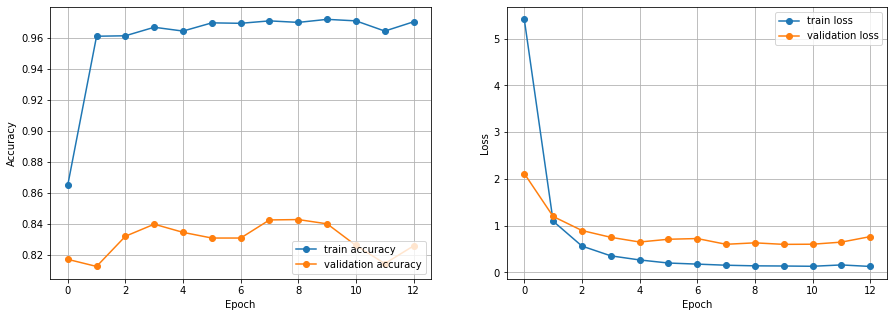

In [61]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

## Testing the model

In [62]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

137/137 [==============================] - 45s 328ms/step - loss: 0.5983 - accuracy: 0.8399
Test accuracy: 0.8399


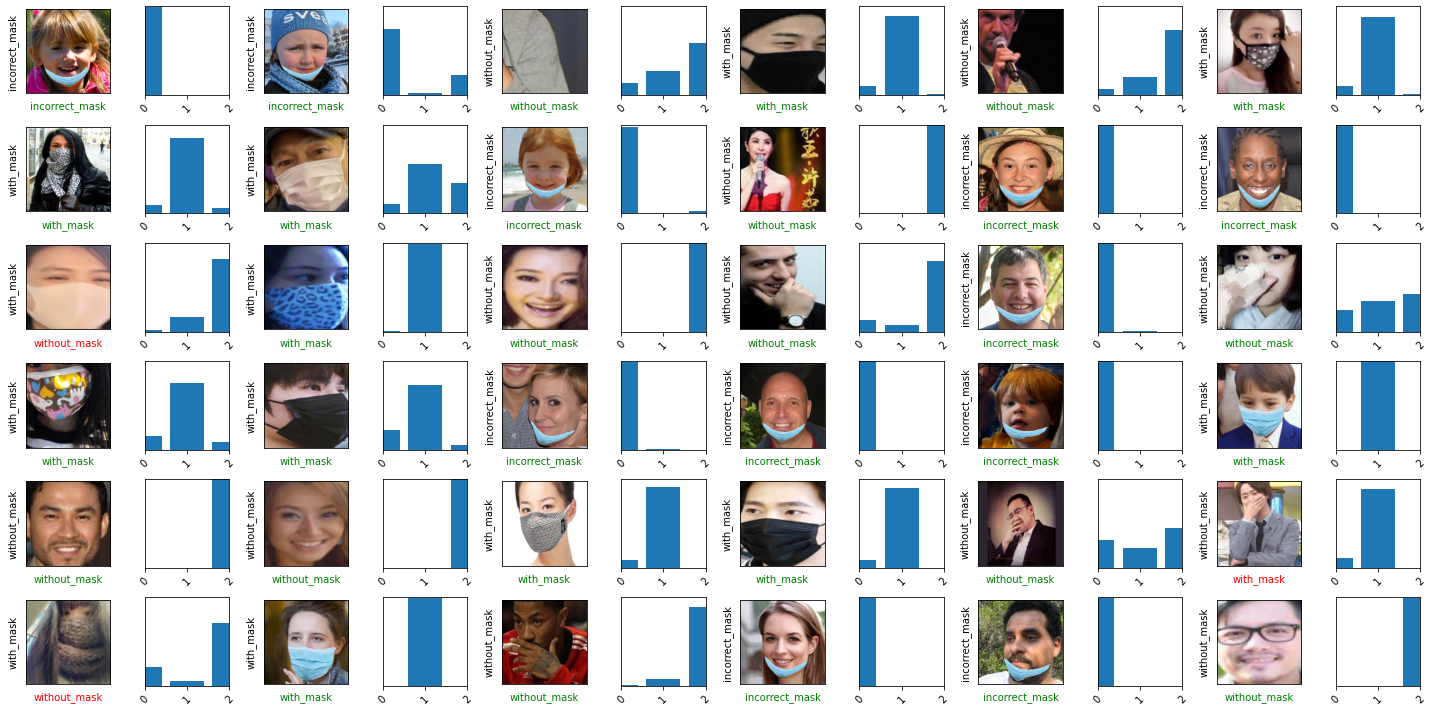

In [63]:
rows = 6
cols = 6

plt.figure(figsize=(20, 10))
for i in range(rows * cols):
    plt.subplot(rows, 2 * cols, 2 * i + 1)
    image, label = test_dataset[i]
    plt.imshow(image[0])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_labels[np.argmax(label)])
    
    prediction = model.predict(np.expand_dims(image[0], axis=0))[0]
    
    if np.argmax(label) == np.argmax(prediction):
        plt.xlabel(class_labels[np.argmax(prediction)], color='g')
    else:
        plt.xlabel(class_labels[np.argmax(prediction)], color='r')

    plt.subplot(rows, 2 * cols, 2 * i + 2)
    plt.bar(range(len(class_labels)), prediction)
    plt.yticks([])
    plt.xticks(range(len(class_labels)), class_labels, rotation=45)
    plt.ylim([0, 1])
    plt.xlim([0, len(class_labels) - 1])

plt.tight_layout()
plt.show()